Creating Script to Classify Digits accepting values for hyperparameters from command line




In [ ]:
#to create files with unique names
!pip install shortuuid

In [ ]:
%%writefile digitsWithHPO.py
import sys
import json
import keras
import tensorflow as tf
from keras.datasets import mnist
#from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras import optimizers
from keras import backend as K
import argparse
import shortuuid

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-t", "--tuner", required=True, type=str,
	choices=["hyperband", "random", "bayesian"],
	help="type of hyperparameter tuner we'll be using")
#ap.add_argument("-p", "--plot", required=True,
#	help="path to output accuracy/loss plot")
ap.add_argument("-lr", "--learningrate", required=False,
  help="value for learningrate")
ap.add_argument("-mo", "--momentum", required=False,
  help="value for momentum")
ap.add_argument("-ep", "--epochs", required=False,
  help="value for epochs")
args = vars(ap.parse_args())



#default lr is 0.01
if float(args["learningrate"]) <= 0:
  learningrate=0.01
else:
  learningrate=float(args["learningrate"])
#default momentum is 0.1
if float(args["momentum"]) <= 0:
  momentum=0.1
else:
  momentum=float(args["momentum"])
#defaul epochs is 2
if float(args["epochs"]) <= 0:
  epochs=2
else:
  epochs=int(args["epochs"])

#  to split the data of training and testing sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Data Preprocessing
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# conversion of class vectors to matrices of  binary class
batch_size = 128
num_classes = 10


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#create model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
#model.compile(loss=keras.losses.categorical_crossentropy,
#            optimizer=tf.keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum),
#            metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy'])
#train
hist = model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose=0,validation_data=(x_test, y_test))
#print("The model has successfully trained")
filename='./modelSaved/'+shortuuid.uuid()+'.h5'
model.save(filename)
#print("Saving the bot as mnist.h5")

#evaluate
score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss: ', score[0])
print('Test Accuracy: ', score[1])

#print model parameters and Test Accuracy to a txt file
#since several files will write needs lock here
#TODO Add model parameters to file so maximun can be found
#and who produced the max
#add error checking here
with open("output.txt", "a") as outfile:
    outfile.write(str(score[1]))
    outfile.write('\n')


Overwriting digitsWithHPO.py


In [ ]:
import time
start = time.time()
#simulating the distributed system/HPO generating the next calls to python script
!python digitsWithHPO.py --t hyperband -ep 10 -lr 0.1 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 200 -lr 0.01 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 20 -lr 0.001 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 5 -lr 0.1 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 10 -lr 0.02 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 10 -lr 0.01 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 30 -lr 0.1 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 40 -lr 0.1 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 100 -lr 0.01 -mo 0.2
!python digitsWithHPO.py --t hyperband -ep 250 -lr 0.1 -mo 0.2
end = time.time()
print(end - start)

2024-08-05 17:34:53.367945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 17:34:53.385700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 17:34:53.408063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 17:34:53.414852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 17:34:53.430034: I tensorflow/core/platform/cpu_feature_guar

Model have been run and the best hyperparameters found; all intermedian (non-optimal) models are saved as h5 file on folder/modelsaved.
To get model (epistemic) uncertainty
1. read each of the files and predict
2. return label prediction and epistemic uncertainty

In [ ]:
import os
import imageio
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error, brier_score_loss
from keras.models import load_model

import keras
from keras.datasets import mnist
#load the mnist handwritten digits dataset, since I created the script the variable x_train is not recognized
#so lets load again the set
#  to split the data of training and testing sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

start = time.time()
# load the model
path = "./modelSaved/"
dir_list = os.listdir(path)\

#Test Predictions in the entire test set
mc_predictions = []
for x in dir_list:
  if x.endswith('.h5'):
    # load model
    model = load_model(path+x)
    # predict digit
    y_p = model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

#Calculate the ensable mean and std
p = np.array(mc_predictions)
y_mean = p.mean(axis=0)
w = 1/np.sum(y_mean, axis=1).reshape(y_mean.shape[0],1)
y_mean = (y_mean*w)
y_std = p.std(axis=0)*w

mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
ensemble_acc = accuracy_score(y_test, mc_ensemble_pred)
print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))
end = time.time()
print(end - start)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
MC-ensemble accuracy: 99.0%
4.321002006530762


Testing On Individual Images

Based on this excelent tutorial by Michel Kana Uncertainty in Deep Learning. How To Measure?
A hands-on tutorial on Bayesian estimation of epistemic and aleatoric uncertainty with Keras. Towards a social acceptance of AI.
https://towardsdatascience.com/my-deep-learning-model-says-sorry-i-dont-know-the-answer-that-s-absolutely-ok-50ffa562cb0b


predicted mean: 4
true label: 4



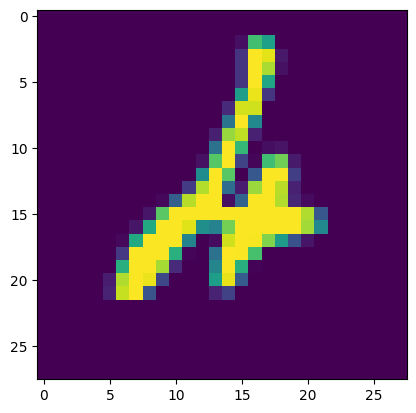

In [ ]:
#2.Image with HIgh uncertainty
idx = 247
plt.imshow(x_test[idx][:,:])
# p0 = np.array([p[idx] for p in mc_predictions])
print("predicted mean: {}".format(y_mean[idx].argmax(axis=0)))
print("true label: {}".format(y_test[idx]))
print()


Text(0.5, 1.0, 'True and predicted class')

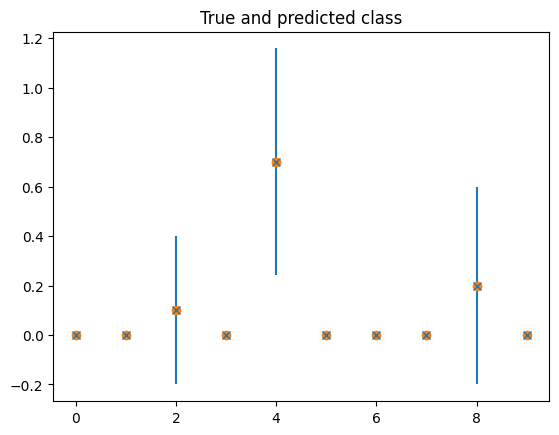

In [ ]:
# probability + variance
plt.errorbar(range(10), y_mean[idx], yerr=y_std[idx], linestyle='None', marker='x')
plt.plot(range(10), y_mean[idx], linestyle='None', marker='o')
plt.title('True and predicted class')

predicted mean: 4
true label: 4



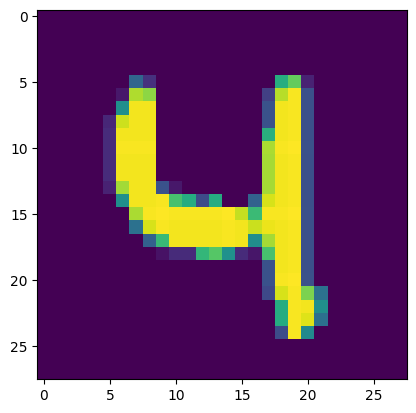

In [ ]:
#2.Image with low uncertainty
idx = 3500
plt.imshow(x_test[idx][:,:])
# p0 = np.array([p[idx] for p in mc_predictions])
print("predicted mean: {}".format(y_mean[idx].argmax(axis=0)))
print("true label: {}".format(y_test[idx]))
print()


Text(0.5, 1.0, 'True and predicted class')

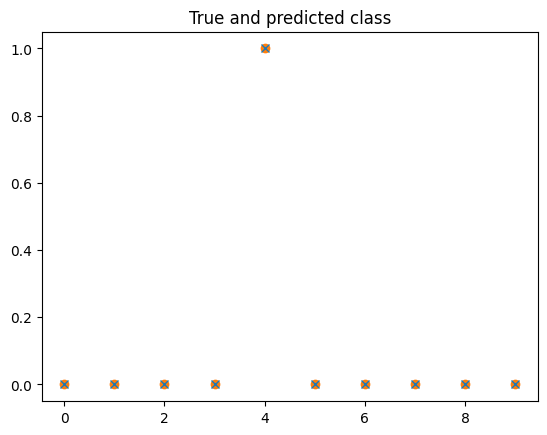

In [ ]:
# probability + variance
plt.errorbar(range(10), y_mean[idx], yerr=y_std[idx], linestyle='None', marker='x')
plt.plot(range(10), y_mean[idx], linestyle='None', marker='o')
plt.title('True and predicted class')

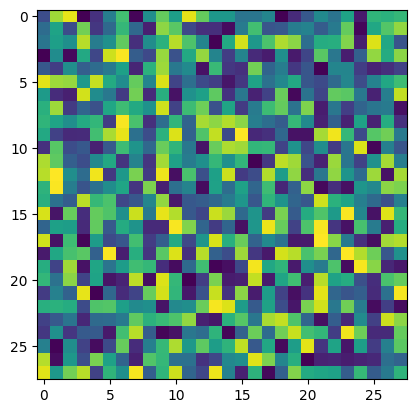

In [ ]:
#Image Random noise
input_shape = (28, 28, 1)
random_img = np.random.random(input_shape)
plt.imshow(random_img[:,:,0]);

In [ ]:
#Test Predictions in the entire test set
random_predictions = []
for x in dir_list:
  if x.endswith('.h5'):
    # load model
    model = load_model(path+x)
    # predict digit
    y_p = model.predict(np.array([random_img]))
    random_predictions.append(y_p)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [ ]:
p0 = np.array([p[0] for p in random_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; proba: {:.1%}; var: {:.2%} ".format(i, prob, var))

posterior mean: 8

class: 0; proba: 0.0%; var: 0.00% 
class: 1; proba: 0.0%; var: 0.00% 
class: 2; proba: 31.8%; var: 39.73% 
class: 3; proba: 0.2%; var: 0.55% 
class: 4; proba: 0.0%; var: 0.02% 
class: 5; proba: 0.1%; var: 0.35% 
class: 6; proba: 0.0%; var: 0.08% 
class: 7; proba: 0.0%; var: 0.00% 
class: 8; proba: 67.7%; var: 39.53% 
class: 9; proba: 0.0%; var: 0.01% 


<ErrorbarContainer object of 3 artists>

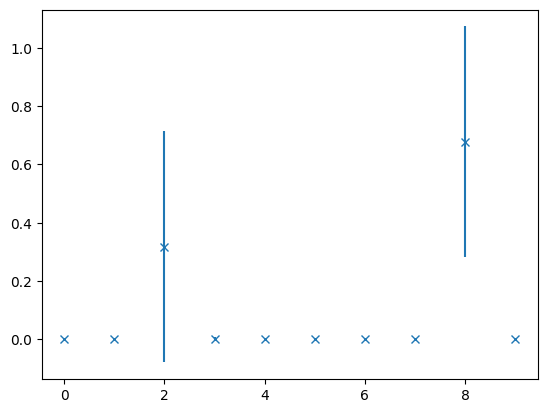

In [ ]:
plt.errorbar(range(10), p0.mean(axis=0), yerr=p0.std(axis=0), ls='None', marker='x')